In [69]:
from typing import Tuple, Union, Optional, List

import torch
import torch.nn as nn
from torch.optim.adamw import AdamW
from torch.optim.sgd import SGD
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

T = torch.Tensor
TN = Optional[T]
TS = Union[Tuple[T, ...], List[T]]

device = torch.device('cuda:3')

# Image Simplification SDS

In [2]:
model_id  =  ["/mnt/d/studying-code/modelscope/stable-diffusion-v1-5"][0]
pipeline = StableDiffusionPipeline.from_pretrained(model_id,).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
def load_512(image_path: str, left=0, right=0, top=0, bottom=0):
    image = np.array(Image.open(image_path))[:, :, :3]    
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image


@torch.no_grad()
def get_text_embeddings(pipe: StableDiffusionPipeline, text: str) -> T:
    tokens = pipe.tokenizer([text], padding="max_length", max_length=77, truncation=True,
                                   return_tensors="pt", return_overflowing_tokens=True).input_ids.to(device)
    return pipe.text_encoder(tokens).last_hidden_state.detach()

@torch.no_grad()
def denormalize(image):
    image = image.to(torch.float32)  # 显式转换类型
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image[0]


@torch.no_grad()
def decode(latent: T, pipe: StableDiffusionPipeline, im_cat: TN = None):
    image = pipeline.vae.decode((1 / 0.18215) * latent, return_dict=False)[0]
    image = denormalize(image)
    if im_cat is not None:
        image = np.concatenate((im_cat, image), axis=1)
    return Image.fromarray(image)

# @torch.no_grad()
# def decode(latent: T, pipe: StableDiffusionPipeline):
#     image = pipeline.vae.decode((1 / 0.18215) * latent, return_dict=False)[0]
#     image = denormalize(image)
#     return Image.fromarray(image)

In [4]:
def init_pipe(device, dtype, unet, scheduler) -> Tuple[UNet2DConditionModel, T, T]:

    with torch.inference_mode():
        alphas = torch.sqrt(scheduler.alphas_cumprod).to(device, dtype=dtype)
        sigmas = torch.sqrt(1 - scheduler.alphas_cumprod).to(device, dtype=dtype)
    for p in unet.parameters():
        p.requires_grad = False
    return unet, alphas, sigmas


class DDSLoss:
 
    def noise_input(self, z, eps=None, timestep: Optional[int] = None):
        if timestep is None:
            b = z.shape[0]
            timestep = torch.randint(
                low=self.t_min,
                high=min(self.t_max, 1000) - 1,  # Avoid the highest timestep.
                size=(b,),
                device=z.device, dtype=torch.long)
        if eps is None:
            eps = torch.randn_like(z)
        alpha_t = self.alphas[timestep, None, None, None]
        sigma_t = self.sigmas[timestep, None, None, None]
        z_t = alpha_t * z + sigma_t * eps
        return z_t, eps, timestep, alpha_t, sigma_t

    def get_eps_prediction(self, z_t: T, timestep: T, text_embeddings: T, alpha_t: T, sigma_t: T, get_raw=False,
                           guidance_scale=7.5):

        latent_input = torch.cat([z_t] * 2)
        timestep = torch.cat([timestep] * 2)
        embedd = text_embeddings.permute(1, 0, 2, 3).reshape(-1, *text_embeddings.shape[2:])
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            e_t = self.unet(latent_input, timestep, embedd).sample
            if self.prediction_type == 'v_prediction':
                e_t = torch.cat([alpha_t] * 2) * e_t + torch.cat([sigma_t] * 2) * latent_input
            e_t_uncond, e_t = e_t.chunk(2)
            if get_raw:
                return e_t_uncond, e_t
            e_t = e_t_uncond + guidance_scale * (e_t - e_t_uncond)
            assert torch.isfinite(e_t).all()
        if get_raw:
            return e_t
        pred_z0 = (z_t - sigma_t * e_t) / alpha_t
        return e_t, pred_z0

    def get_sds_loss(self, z: T, text_embeddings: T, eps: TN = None, mask=None, t=None,  
                 timestep: Optional[int] = None, guidance_scale=7.5) -> TS:
        with torch.inference_mode():
            z_t, eps, timestep, alpha_t, sigma_t = self.noise_input(z, eps=eps, timestep=timestep)
            e_t, _ = self.get_eps_prediction(z_t, timestep, text_embeddings, alpha_t, sigma_t,
                                             guidance_scale=guidance_scale)
            grad_z = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (e_t - eps)
            assert torch.isfinite(grad_z).all()
            grad_z = torch.nan_to_num(grad_z.detach(), 0.0, 0.0, 0.0)
            if mask is not None:
                grad_z = grad_z * mask
            log_loss = (grad_z ** 2).mean()
        sds_loss = grad_z.clone() * z
        del grad_z
        return sds_loss.sum() / (z.shape[2] * z.shape[3]), log_loss

    def __init__(self, device, pipe: StableDiffusionPipeline, dtype=torch.float32):
        self.t_min = 50
        self.t_max = 950
        self.alpha_exp = 0
        self.sigma_exp = 0
        self.dtype = dtype
        self.unet, self.alphas, self.sigmas = init_pipe(device, dtype, pipe.unet, pipe.scheduler)
        self.prediction_type = pipe.scheduler.prediction_type

In [5]:
def image_optimization(pipe: StableDiffusionPipeline, image: np.ndarray, text_source: str, text_target: str, num_iters=200) -> None:
    dds_loss = DDSLoss(device, pipe)
    image_source = torch.from_numpy(image).float().permute(2, 0, 1) / 127.5 - 1
    image_source = image_source.unsqueeze(0).to(device)
    with torch.no_grad():
        z_source = pipeline.vae.encode(image_source)['latent_dist'].mean * 0.18215
        image_target = image_source.clone()
        embedding_null = get_text_embeddings(pipeline, "")
        embedding_text = get_text_embeddings(pipeline, text_source)
        embedding_text_target = get_text_embeddings(pipeline, text_target)
        embedding_source = torch.stack([embedding_null, embedding_text], dim=1)
        embedding_target = torch.stack([embedding_null, embedding_text_target], dim=1)

    guidance_scale = 7.5
    image_target.requires_grad = True
    use_dds_loss = True

    z_taregt = z_source.clone()
    z_taregt.requires_grad = True
    optimizer = SGD(params=[z_taregt], lr=1e-1)
    
    for i in range(num_iters):
        loss, log_loss = dds_loss.get_sds_loss(z_taregt, embedding_target)
        optimizer.zero_grad()
        (2000 * loss).backward()
        optimizer.step()
        if (i + 1) % 10 == 0:
            out = decode(z_taregt, pipeline)
            clear_output(wait=True)
            display(out)

    return out

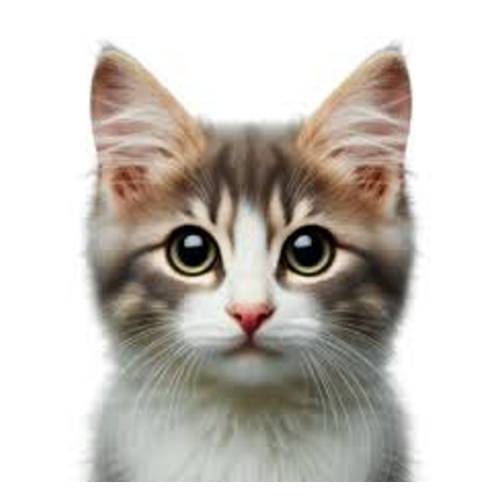

In [210]:
import matplotlib.pyplot as plt
input_file = "./images/cats/cat12.png"
image = load_512(input_file)
plt.figure(figsize=(3, 3), dpi=200)
plt.imshow(image)
plt.axis('off')
plt.show()

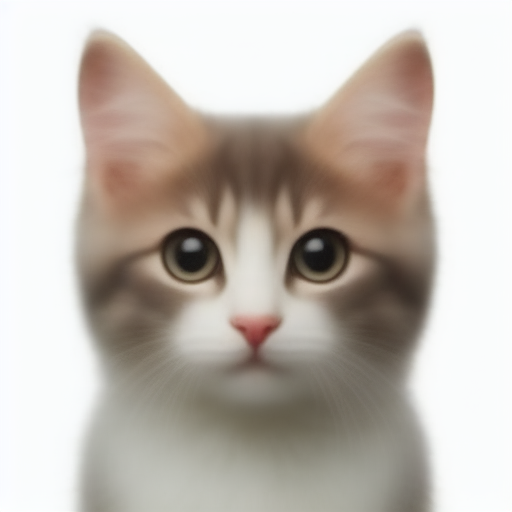

In [211]:
out = image_optimization(pipeline, image, "", "", num_iters=40)

## Image Segmentation sam2

In [170]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda:3")
print(f"using device: {device}")
# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

using device: cuda:3


In [171]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

In [172]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=True)

In [173]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,                  # 增加采样点数以捕获更多细节
    points_per_batch=128,                 # 扩大批处理点数，提高效率
    pred_iou_thresh=0.8,                  # 提高预测 IOU 阈值，生成更精确的 mask
    stability_score_thresh=0.92,          # 提高稳定性分数阈值，仅保留高质量区域
    stability_score_offset=0.7,           # 略微增大偏移量，使 mask 更贴近实际边界
    crop_n_layers=1,                      # 增加裁剪层数，更全面地覆盖猫脸细节
    box_nms_thresh=0.7,                   # 降低 NMS 阈值，允许更多重叠区域（捕获眼睛和耳朵等小特征）
    crop_n_points_downscale_factor=2,     # 不缩放裁剪点数，保留细节
    min_mask_region_area=25,               # 降低最小分割面积阈值，捕获细小的面部特征
    use_m2m=True,                         # 使用 Mask-to-Mask 方法，提升 mask 的边界质量
)

In [212]:
sds_image = np.array(out.convert("RGB"))
masks = mask_generator.generate(sds_image)

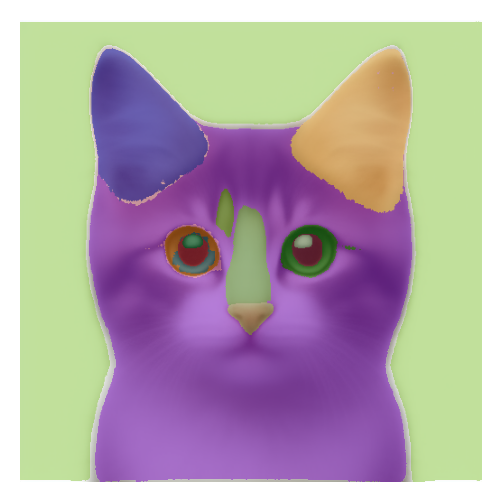

In [213]:
plt.figure(figsize=(3, 3), dpi=200)
plt.imshow(sds_image)
show_anns(masks,borders=False)
plt.axis('off')
plt.show()

# Primitive Fitting

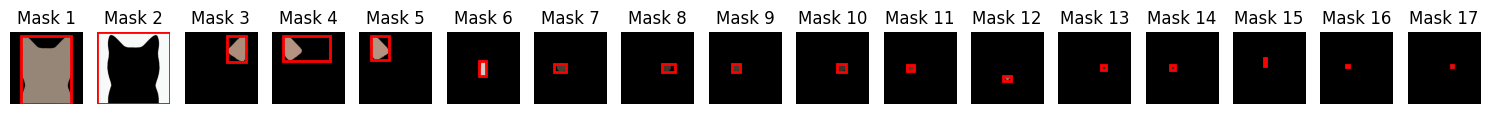

In [214]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the output to a numpy array
image_np = np.array(out)

# Sort the annotations by area in descending order
sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)

# Create a figure with subplots
fig, axs = plt.subplots(1, len(sorted_anns), figsize=(15, 5))

# Ensure axs is a list even if there's only one subplot
if len(sorted_anns) == 1:
    axs = [axs]

for i, mask in enumerate(sorted_anns):
    segmentation = mask['segmentation']  # (H, W) boolean array
    bbox = mask['bbox']  # [x, y, width, height]
    
    # Extract the region pixels from the original image
    region_pixels = image_np[segmentation]
    
    # Calculate the mean color of the region
    mean_color = region_pixels.mean(axis=0).astype(np.uint8)  # (R, G, B)
    
    # Create a colored mask image with the mean color
    colored_mask = np.zeros_like(image_np)
    colored_mask[segmentation] = mean_color
    
    # Display the colored mask in the subplot
    axs[i].imshow(colored_mask)
    
    # Create a Rectangle patch for the bounding box
    rect = plt.Rectangle(
        (bbox[0], bbox[1]), bbox[2], bbox[3],
        linewidth=2, edgecolor='red', facecolor='none'
    )
    
    # Add the patch to the subplot
    axs[i].add_patch(rect)
    
    # Set title and remove axis
    axs[i].set_title(f"Mask {i+1}")
    axs[i].axis('off')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

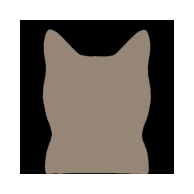

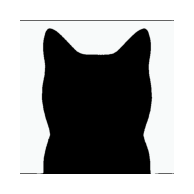

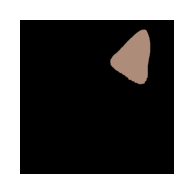

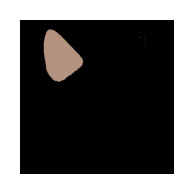

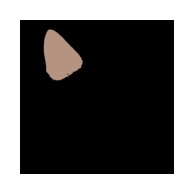

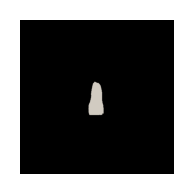

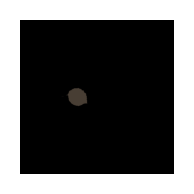

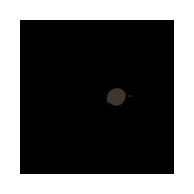

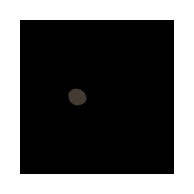

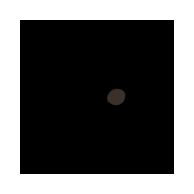

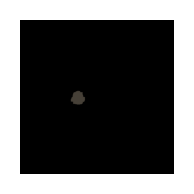

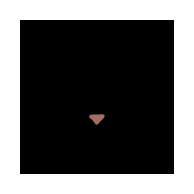

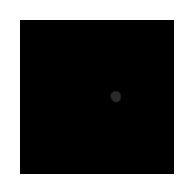

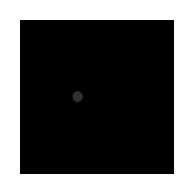

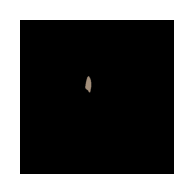

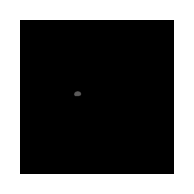

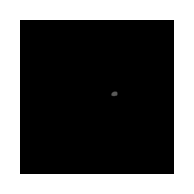

In [215]:
image_np = np.array(out)
# 假设 masks 是分割结果
# 创建一个空白图像，用于存储彩色分割结果
colored_masks = np.zeros_like(image_np)

for mask in sorted_anns:
    segmentation = mask['segmentation']  # 获取分割的二值掩码 (H, W)
    
    # 提取原图像中该区域的像素值
    region_pixels = image_np[segmentation]
    
    # 计算平均颜色
    mean_color = region_pixels.mean(axis=0).astype(np.uint8)  # (R, G, B)
    
    # 创建彩色区域
    colored_mask = np.zeros_like(image_np)
    colored_mask[segmentation] = mean_color  # 将平均颜色填充到对应区域

    plt.figure(figsize=(1, 1), dpi=200)
    plt.imshow(colored_mask)
    plt.axis('off')
    plt.show()
    # 合并到总图像
    # colored_masks[segmentation] = mean_color

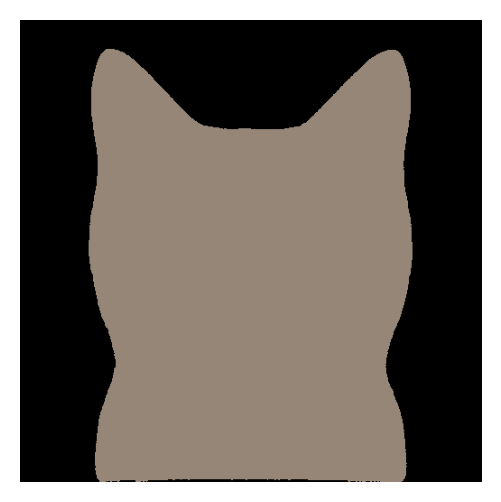

In [216]:
import primipy
from PIL import Image
import matplotlib.pyplot as plt

# 读取并预处理图像
image_np = np.array(out)
segmentation = sorted_anns[0]['segmentation']
# 提取原图像中该区域的像素值
region_pixels = image_np[segmentation]
# 计算平均颜色
mean_color = region_pixels.mean(axis=0).astype(np.uint8)  # (R, G, B)
# 创建彩色区域
colored_mask = np.zeros_like(image_np)
colored_mask[segmentation] = mean_color  # 将平均颜色填充到对应区域

plt.figure(figsize=(3, 3), dpi=200)
plt.imshow(colored_mask)
plt.axis('off')
plt.show()

In [217]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_error(segmentation, shape_mask):
    """
    计算误差：综合面积差和边界不匹配的惩罚
    """
    intersection = np.sum(segmentation & shape_mask)
    union = np.sum(segmentation | shape_mask)
    boundary_mismatch = np.sum(shape_mask & ~segmentation)  # 超出区域的像素数量
    if union == 0:
        return float("inf")
    return 1 - intersection / union + 0.01 * boundary_mismatch  # 综合面积和边界

def generate_shape_mask(params, shape_type, image_size):
    """
    根据参数生成图形掩码
    """
    mask = np.zeros(image_size, dtype=bool)
    h, w = image_size
    y, x = np.ogrid[:h, :w]

    if shape_type == "circle":
        cx, cy, r = params
        mask = (x - cx)**2 + (y - cy)**2 <= r**2

    elif shape_type == "ellipse":
        cx, cy, a, b, theta = params
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        x_shifted, y_shifted = x - cx, y - cy
        x_rotated = cos_theta * x_shifted + sin_theta * y_shifted
        y_rotated = -sin_theta * x_shifted + cos_theta * y_shifted
        mask = (x_rotated / a)**2 + (y_rotated / b)**2 <= 1

    elif shape_type == "rectangle":
        cx, cy, w, h, theta = params
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        x_shifted, y_shifted = x - cx, y - cy
        x_rotated = cos_theta * x_shifted + sin_theta * y_shifted
        y_rotated = -sin_theta * x_shifted + cos_theta * y_shifted
        mask = (np.abs(x_rotated) <= w / 2) & (np.abs(y_rotated) <= h / 2)

    elif shape_type == "triangle":
        x1, y1, x2, y2, x3, y3 = params
        triangle = np.zeros(image_size, dtype=bool)
        # 使用稠密网格进行像素包含测试
        for i in range(h):
            for j in range(w):
                p = np.array([j, i])
                v0 = np.array([x3 - x1, y3 - y1])
                v1 = np.array([x2 - x1, y2 - y1])
                v2 = np.array([p[0] - x1, p[1] - y1])
                dot00 = np.dot(v0, v0)
                dot01 = np.dot(v0, v1)
                dot02 = np.dot(v0, v2)
                dot11 = np.dot(v1, v1)
                dot12 = np.dot(v1, v2)
                inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
                u = (dot11 * dot02 - dot01 * dot12) * inv_denom
                v = (dot00 * dot12 - dot01 * dot02) * inv_denom
                if u >= 0 and v >= 0 and (u + v) <= 1:
                    triangle[i, j] = True
        return triangle

    return mask

def shape_constraint(params, segmentation, shape_type, image_size):
    """
    约束条件：图形必须完全在分割区域内
    """
    shape_mask = generate_shape_mask(params, shape_type, image_size)
    return np.sum(shape_mask & ~segmentation) == 0  # 确保无像素点超出分割区域

def fit_shape(segmentation, shape_type, initial_params, bounds, image_size):
    """
    优化形状参数以最小化误差，同时添加约束条件
    """
    def objective(params):
        shape_mask = generate_shape_mask(params, shape_type, image_size)
        return calculate_error(segmentation, shape_mask)

    # 约束条件
    constraints = {
        "type": "ineq",
        "fun": lambda params: -np.sum(~generate_shape_mask(params, shape_type, image_size) & segmentation) + 1e-5
    }

    result = minimize(objective, initial_params, bounds=bounds, constraints=constraints)
    return result.x, result.fun

def get_initial_params_and_bounds(segmentation, shape_type):
    """
    根据分割区域生成初始参数和边界
    """
    h, w = segmentation.shape
    y, x = np.nonzero(segmentation)
    cx, cy = np.mean(x), np.mean(y)

    if shape_type == "circle":
        r = np.sqrt((x.max() - x.min())**2 + (y.max() - y.min())**2) / 2
        return [cx, cy, r], [(0, w), (0, h), (1, max(w, h))]

    elif shape_type == "ellipse":
        a, b = (x.max() - x.min()) / 2, (y.max() - y.min()) / 2
        return [cx, cy, a, b, 0], [(0, w), (0, h), (1, max(w, h)), (1, max(w, h)), (0, 2 * np.pi)]

    elif shape_type == "rectangle":
        w, h = x.max() - x.min(), y.max() - y.min()
        return [cx, cy, w, h, 0], [(0, w), (0, h), (1, max(w, h)), (1, max(w, h)), (0, 2 * np.pi)]

    elif shape_type == "triangle":
        return [x.min(), y.min(), x.max(), y.min(), x.mean(), y.max()], [(0, w), (0, h)] * 3

def fit_all_shapes(segmentation):
    """
    对所有基础图形拟合，并选择误差最小的结果
    """
    shapes = ['circle', 'ellipse', 'rectangle', 'triangle']
    best_shape = None
    best_error = float('inf')
    best_params = None

    for shape_type in shapes:
        initial_params, bounds = get_initial_params_and_bounds(segmentation, shape_type)
        params, error = fit_shape(segmentation, shape_type, initial_params, bounds, segmentation.shape)
        if error < best_error:
            best_shape = shape_type
            best_error = error
            best_params = params

    return best_shape, best_params, best_error

def generate_colored_shape(image_np, segmentation, shape_type, params):
    """
    根据基础图形掩码填充颜色
    """
    h, w, _ = image_np.shape
    mask = generate_shape_mask(params, shape_type, (h, w))  # 使用之前的生成函数

    # 提取分割区域的像素值并计算平均颜色
    region_pixels = image_np[segmentation]
    mean_color = region_pixels.mean(axis=0).astype(np.uint8)  # (R, G, B)

    # 创建一个新图层，将基础图形区域填充为平均颜色
    colored_shape = np.zeros_like(image_np)
    for c in range(3):  # R, G, B 通道
        colored_shape[:, :, c][mask] = mean_color[c]

    return colored_shape

def overlay_shapes(original_image, colored_shape):
    """
    将彩色基础图形覆盖到原图像上
    """
    overlayed_image = original_image.copy()
    mask = np.any(colored_shape > 0, axis=-1)  # 判断非零区域
    overlayed_image[mask] = colored_shape[mask]
    return overlayed_image

最佳图形: ellipse, 参数: [255.18640661 291.43996519 179.         239.5          0.        ], 误差: 122.81223961948182


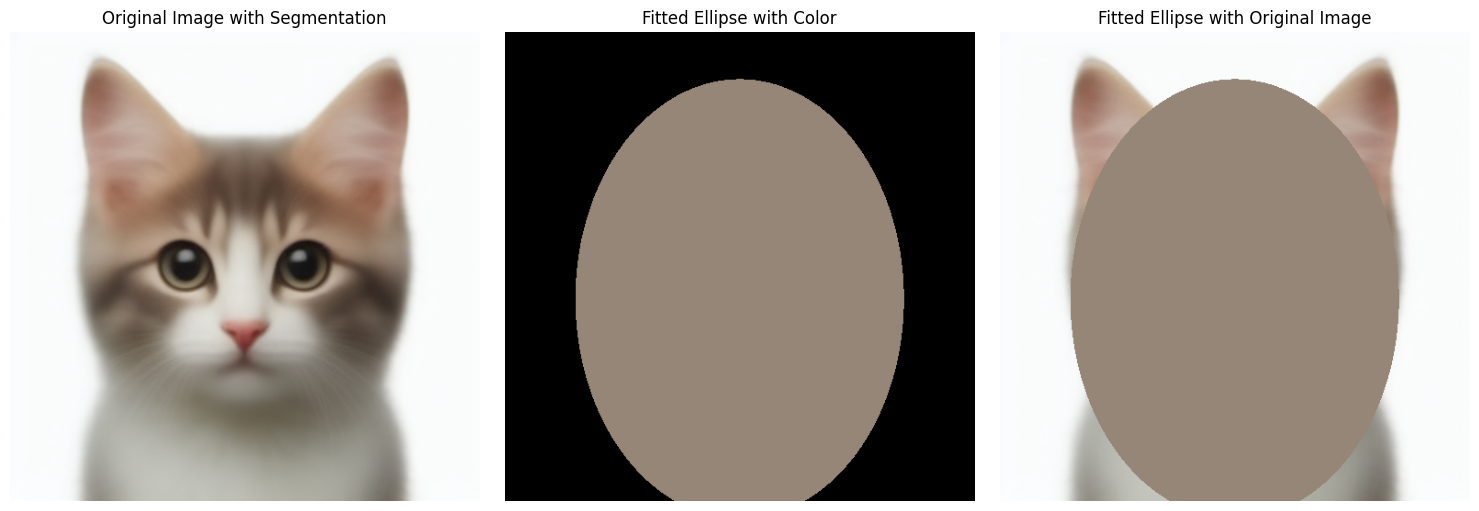

/tmp/ipykernel_2592844/3252086124.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
/tmp/ipykernel_2592844/3252086124.py:60: RuntimeWarning: invalid value encountered in scalar multiply
  u = (dot11 * dot02 - dot01 * dot12) * inv_denom
/tmp/ipykernel_2592844/3252086124.py:61: RuntimeWarning: invalid value encountered in scalar multiply
  v = (dot00 * dot12 - dot01 * dot02) * inv_denom


最佳图形: triangle, 参数: [  0.           1.49902329 510.50097671   1.49902329 256.27011869
 511.        ], 误差: 909.8552419736011


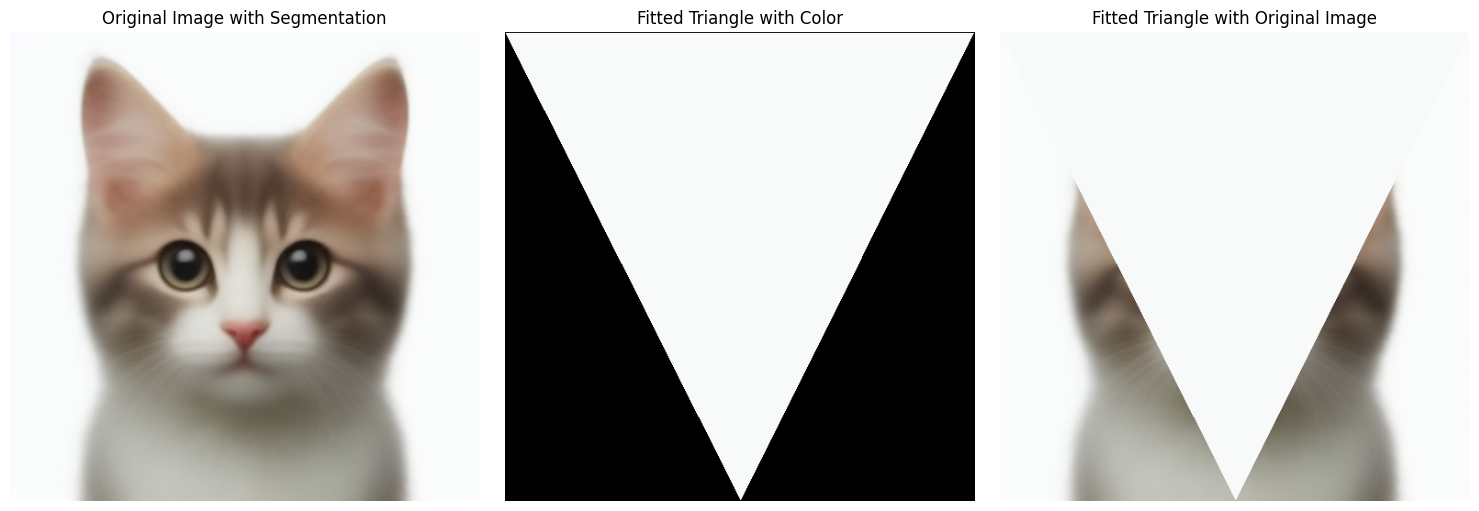

最佳图形: triangle, 参数: [299.          31.         432.          31.         378.65176379
 213.        ], 误差: 36.74354244122113


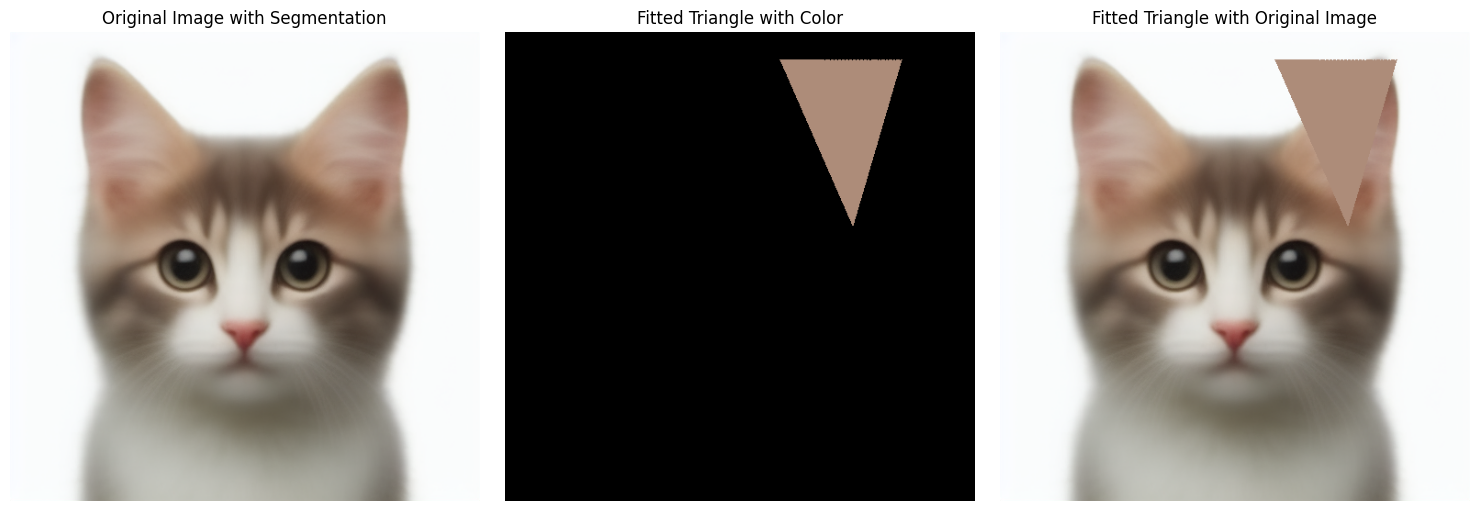

最佳图形: triangle, 参数: [ 79.         31.        413.         31.        133.0863844 205.       ], 误差: 181.6103687198584


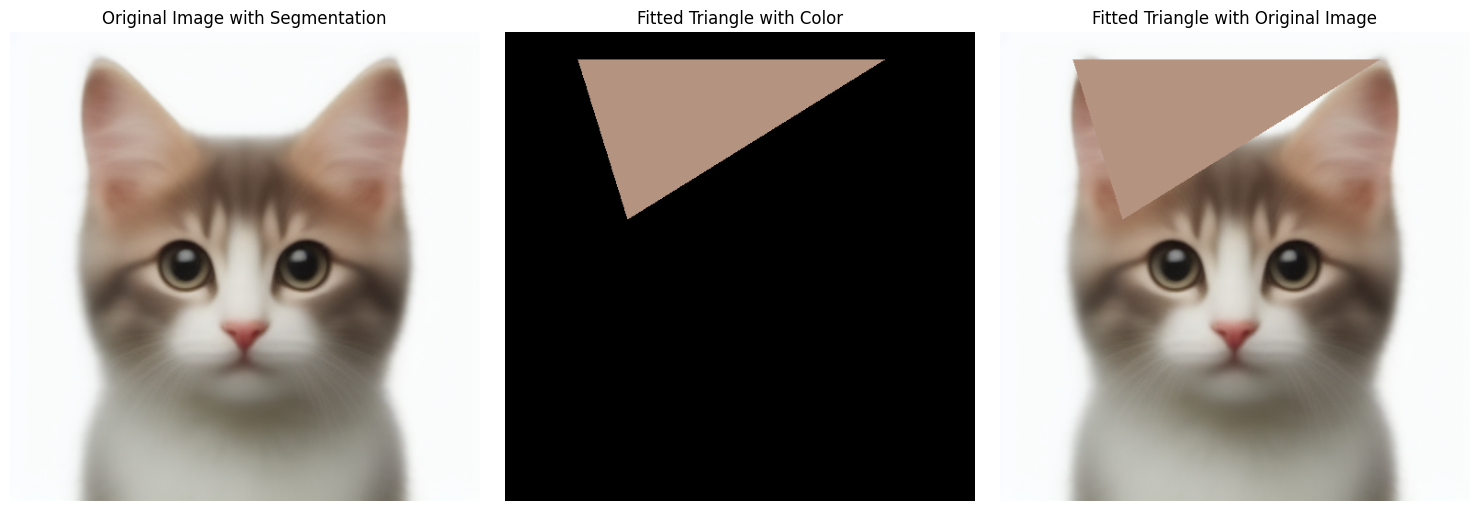

最佳图形: triangle, 参数: [ 79.          31.         207.          31.         132.63227017
 200.        ], 误差: 33.289325709109434


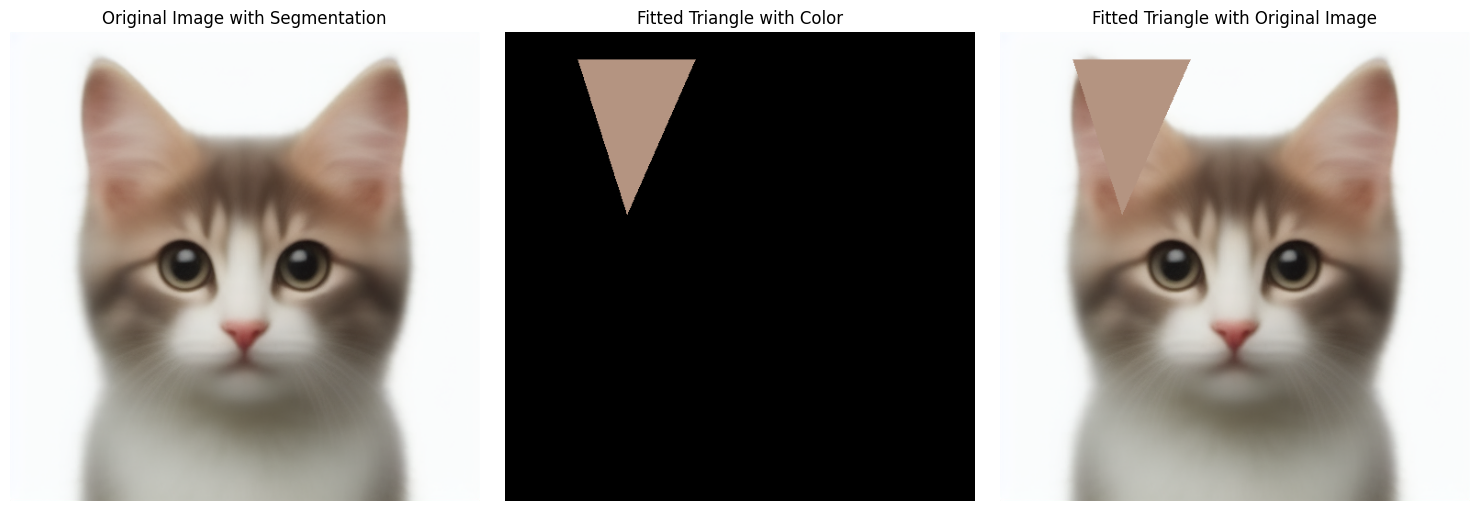

最佳图形: triangle, 参数: [226.77832043 205.29980453 276.72949233 205.29980453 253.01751065
 315.        ], 误差: 5.744653465346534


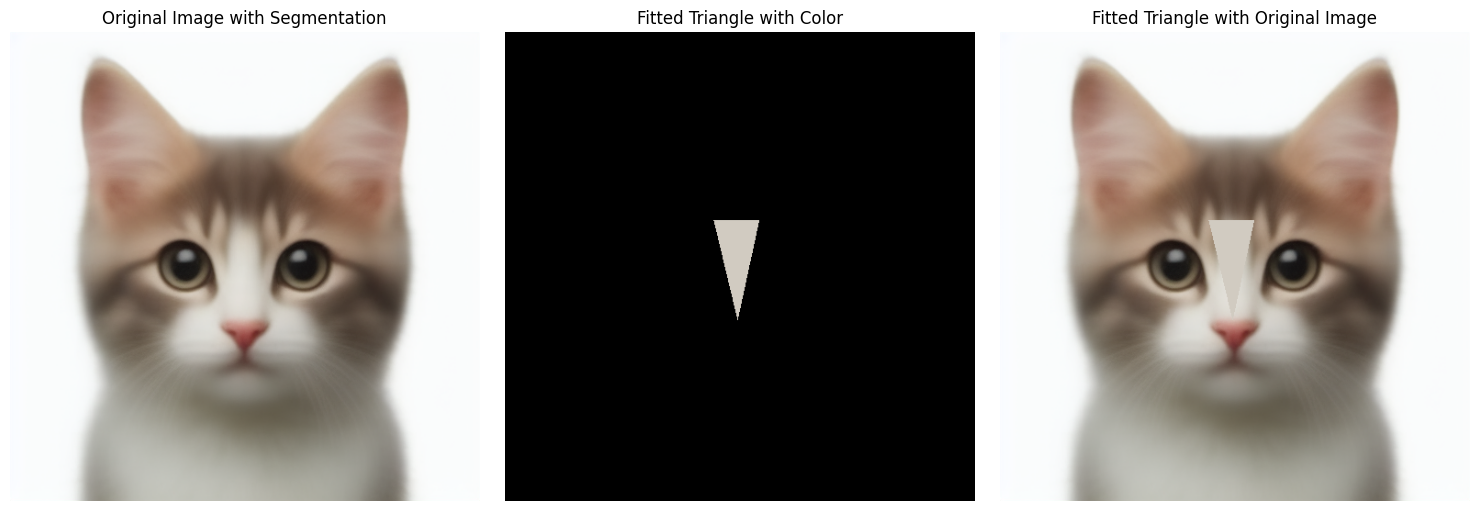

最佳图形: triangle, 参数: [139.         226.         223.         226.         190.62990782
 285.        ], 误差: 5.960574712643678


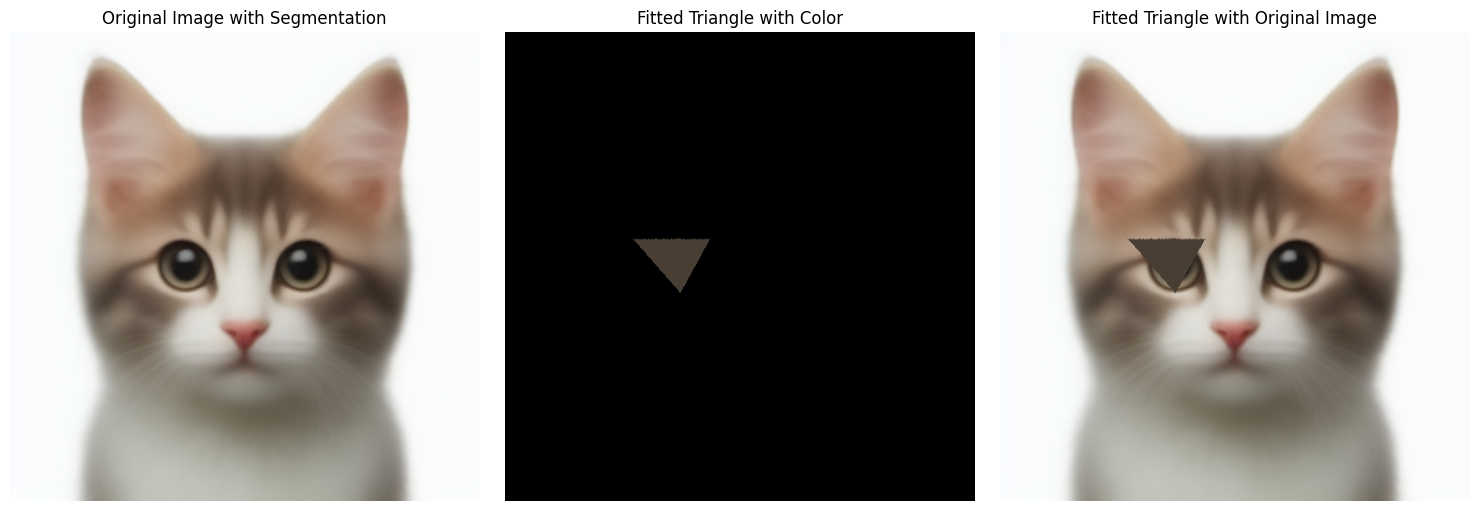

最佳图形: triangle, 参数: [288.         227.         377.         227.         320.44429113
 285.        ], 误差: 6.894977426636569


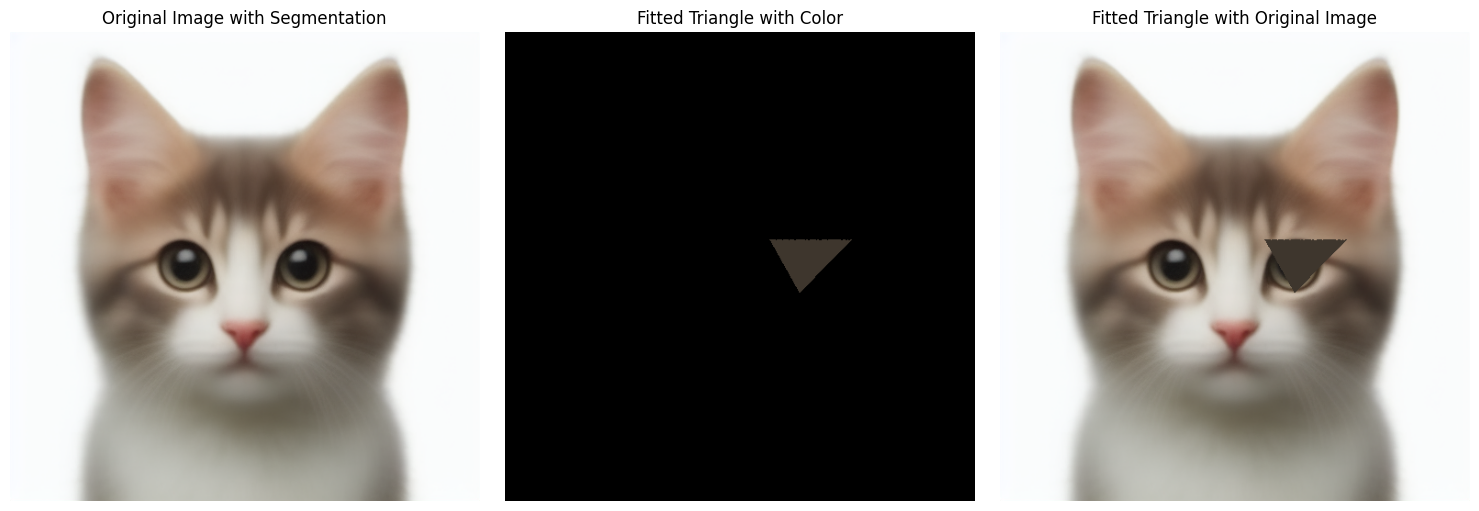

最佳图形: ellipse, 参数: [189.97582502 255.63967767  30.          27.5          0.        ], 误差: 0.9198625046451133


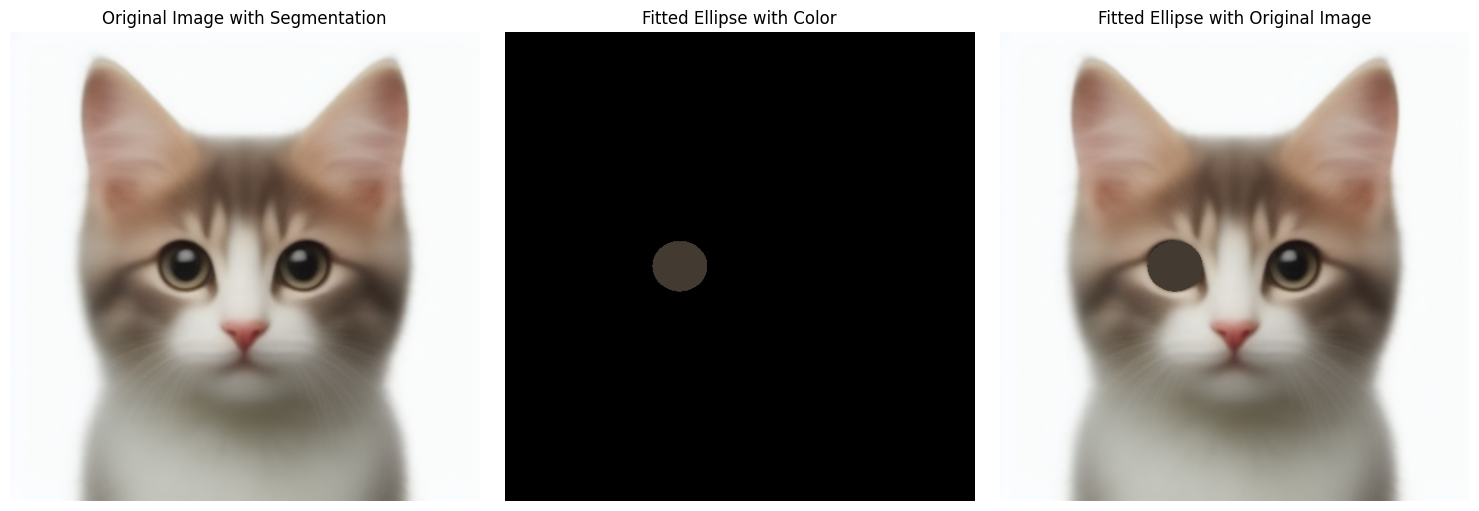

最佳图形: ellipse, 参数: [319.80889236 255.47386895  29.5         26.5          0.        ], 误差: 0.49521105141980043


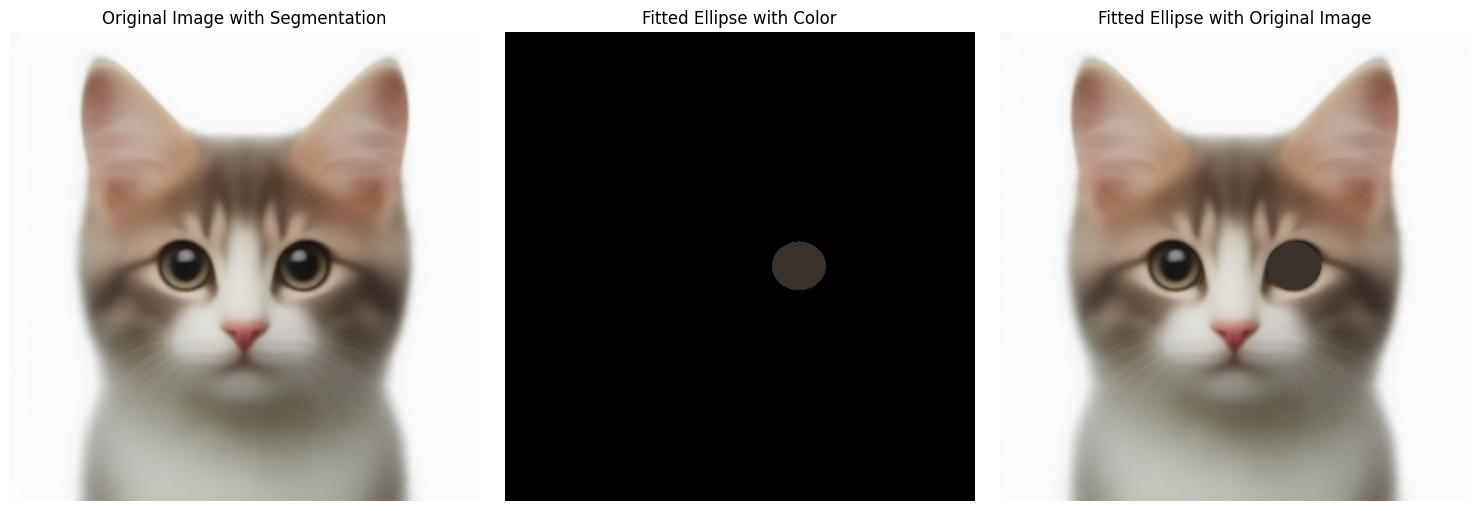

最佳图形: ellipse, 参数: [192.30473752 259.25160051  23.          22.5          0.        ], 误差: 1.414066193853428


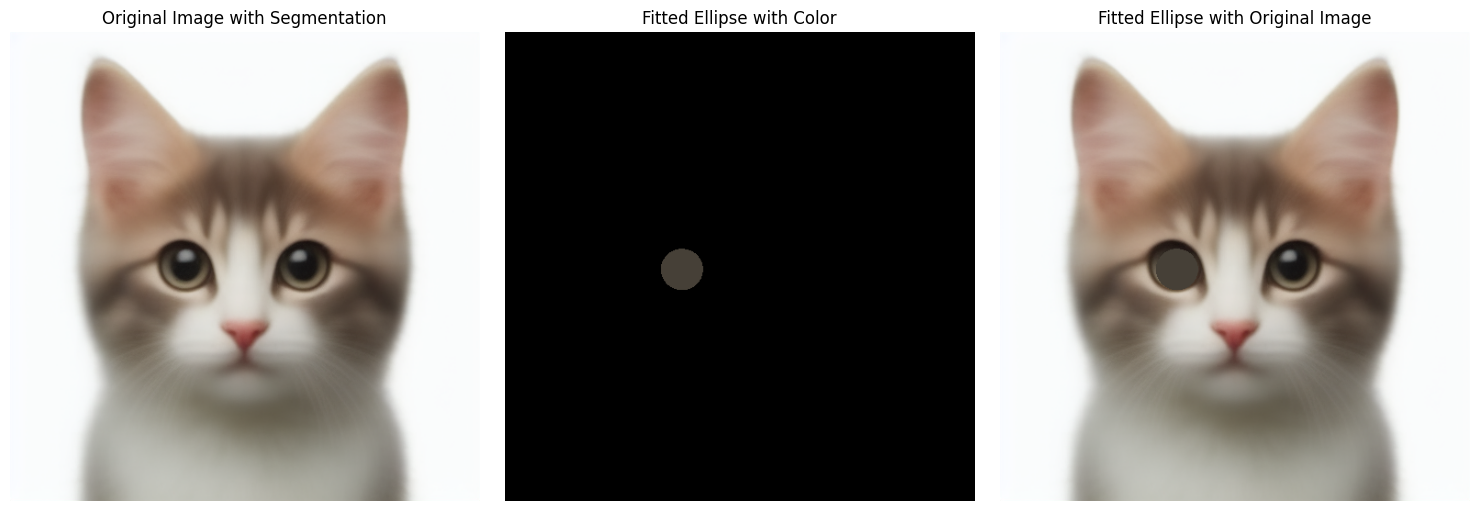

最佳图形: triangle, 参数: [230.27539059 313.19433591 280.22656247 313.19433591 255.45373665
 348.        ], 误差: 0.37968309859154925


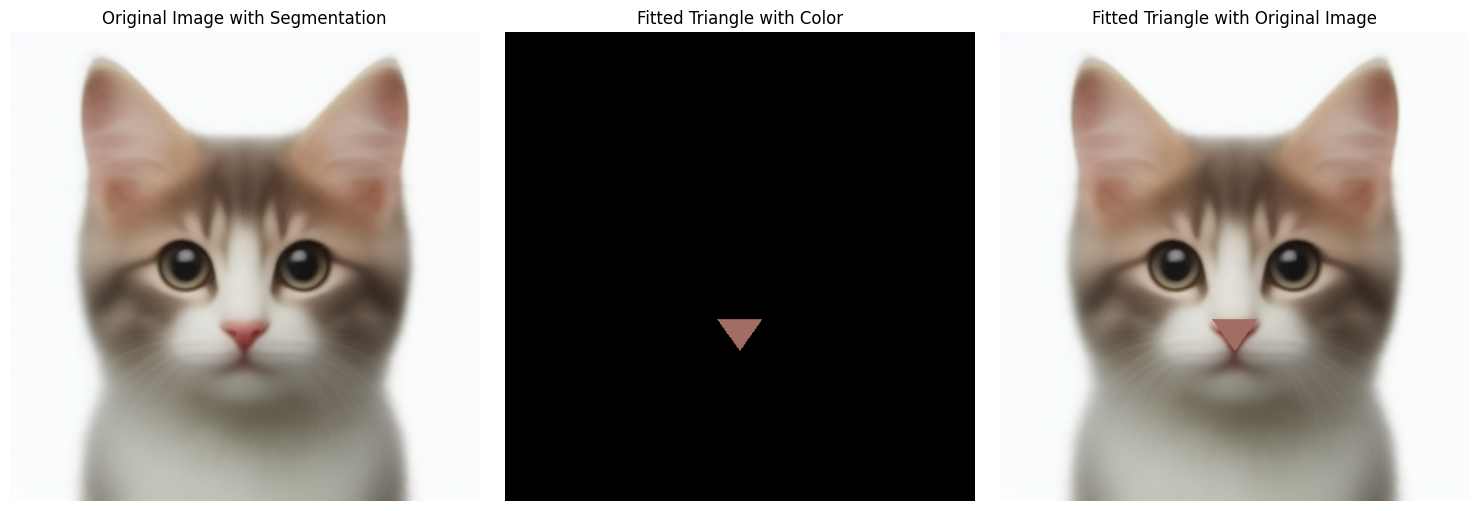

最佳图形: ellipse, 参数: [318.22822823 254.01401401  16.5         17.5          0.        ], 误差: 0.09009009009009006


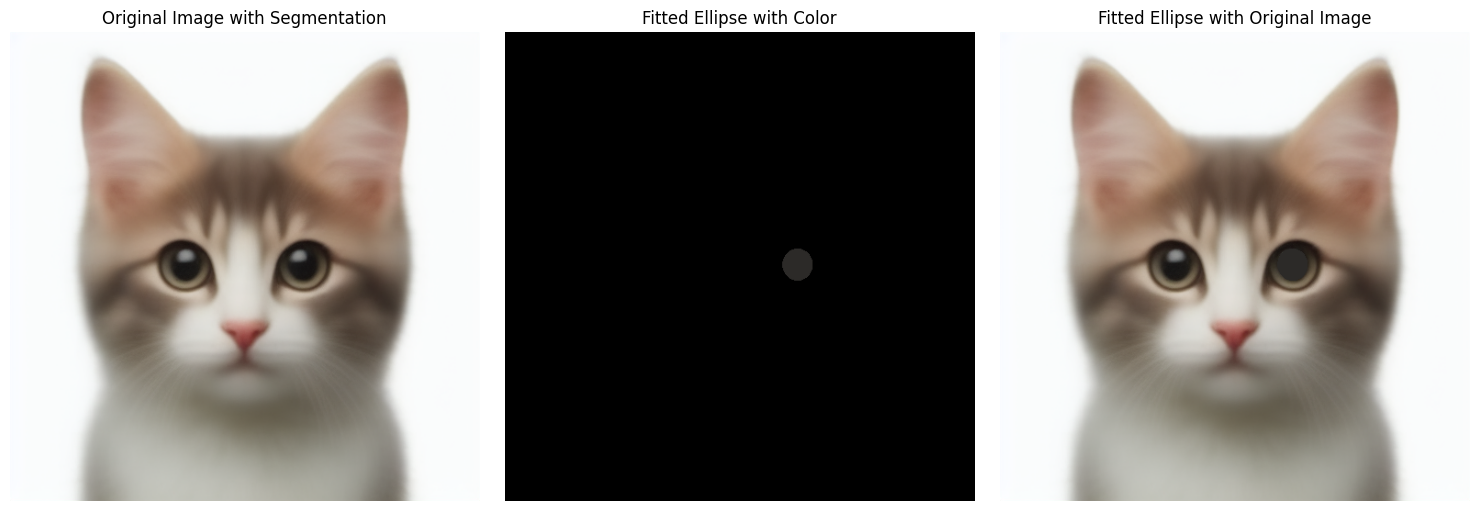

最佳图形: ellipse, 参数: [191.0966736 254.3024948  16.5        17.5         0.       ], 误差: 0.05509355509355507


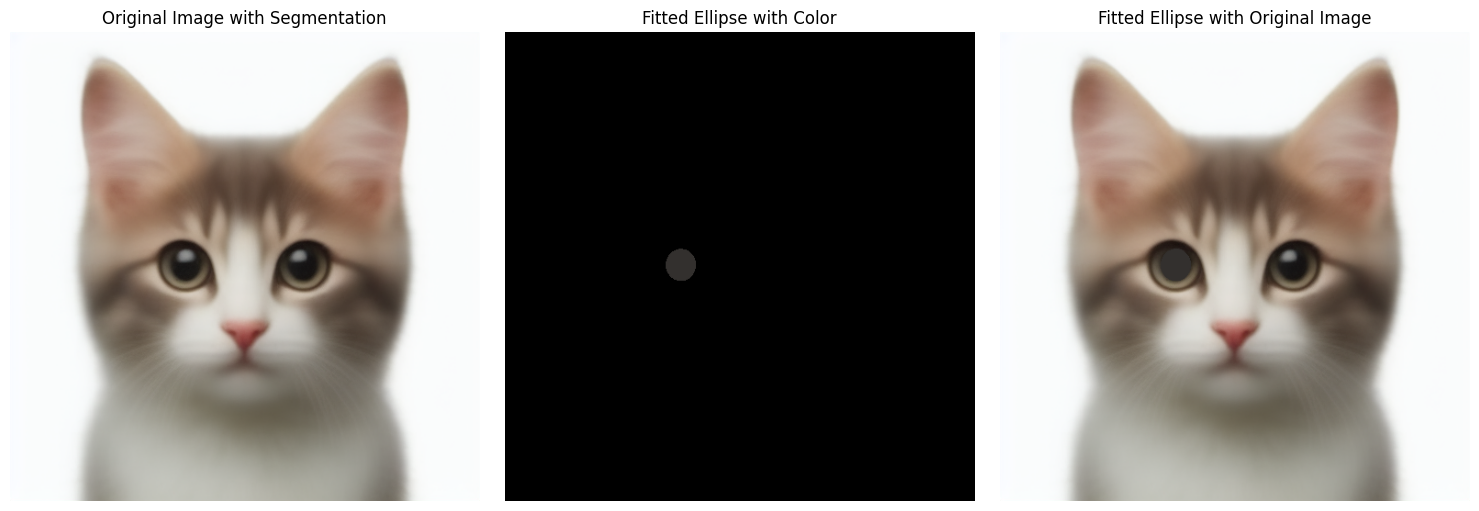

最佳图形: ellipse, 参数: [227.3672391  213.70937913   9.5         26.5          0.        ], 误差: 0.8048484848484849


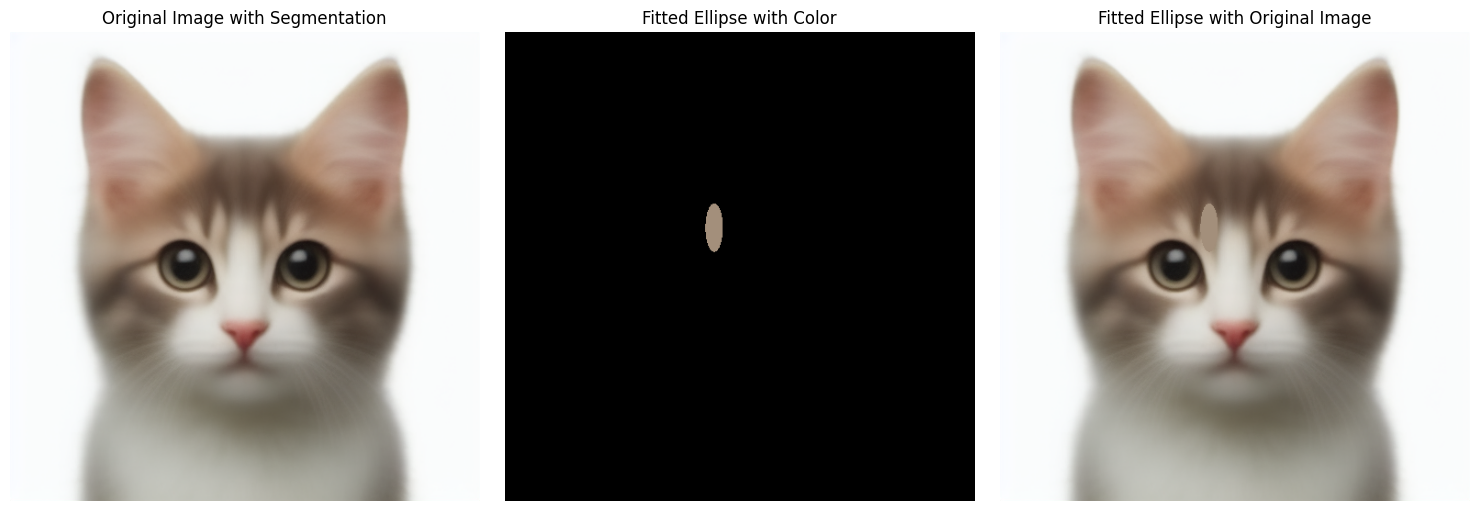

最佳图形: ellipse, 参数: [191.04318937 244.98006645  11.           7.5          0.        ], 误差: 0.13289036544850497


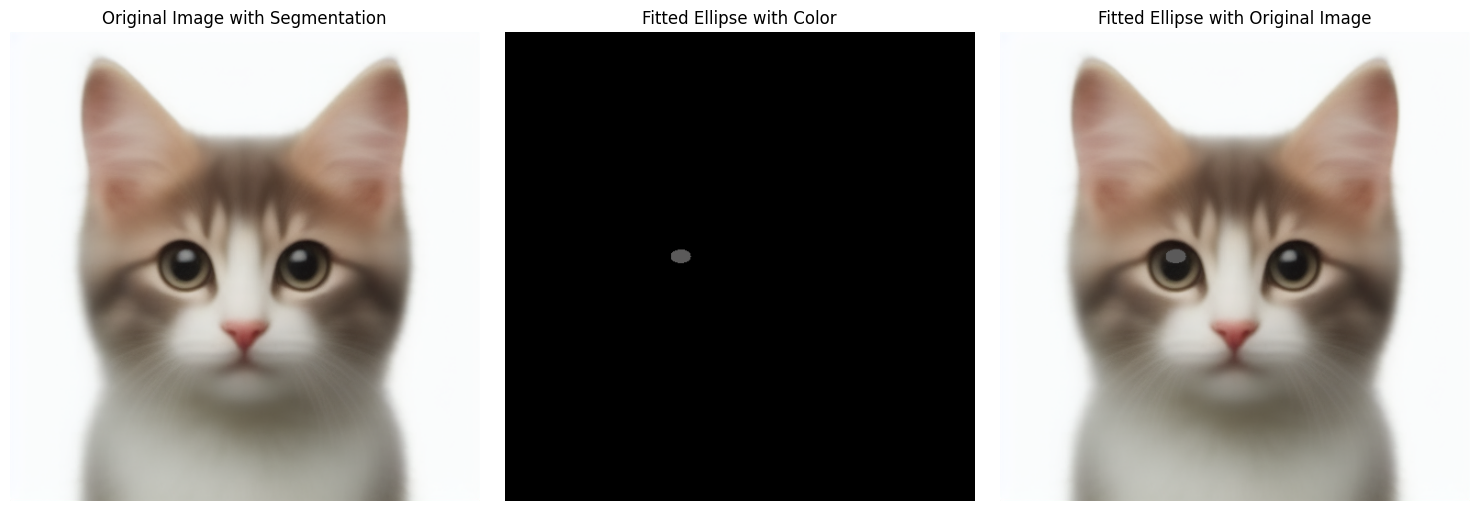

最佳图形: ellipse, 参数: [313.82071713 245.21513944   9.5          7.           0.        ], 误差: 0.17666666666666664


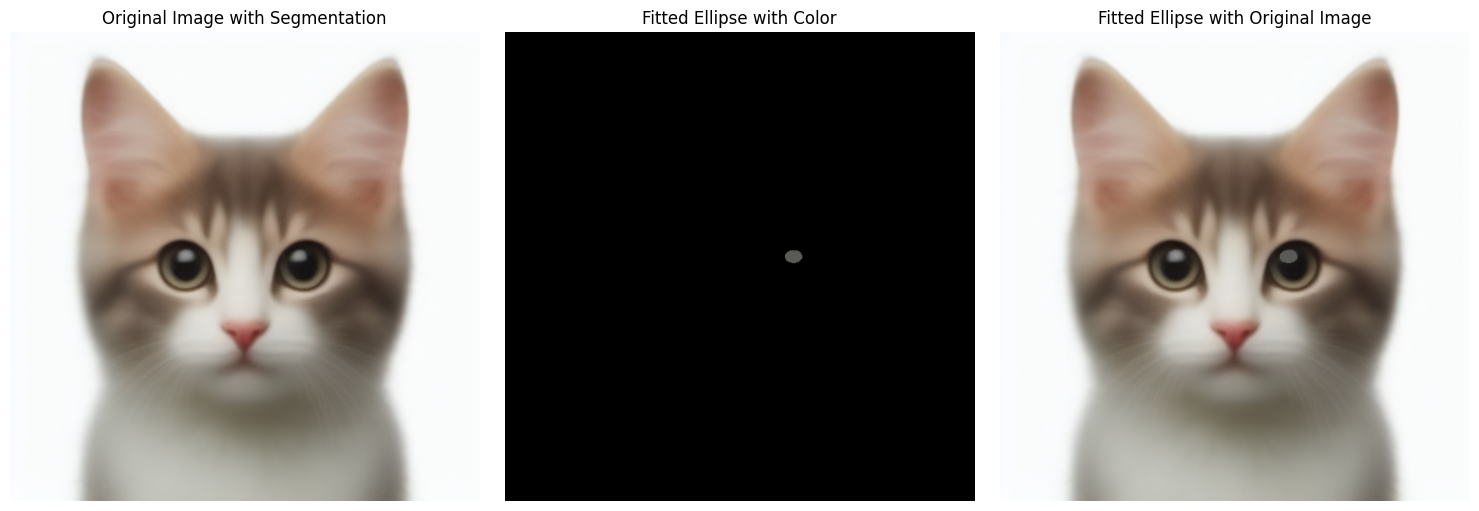

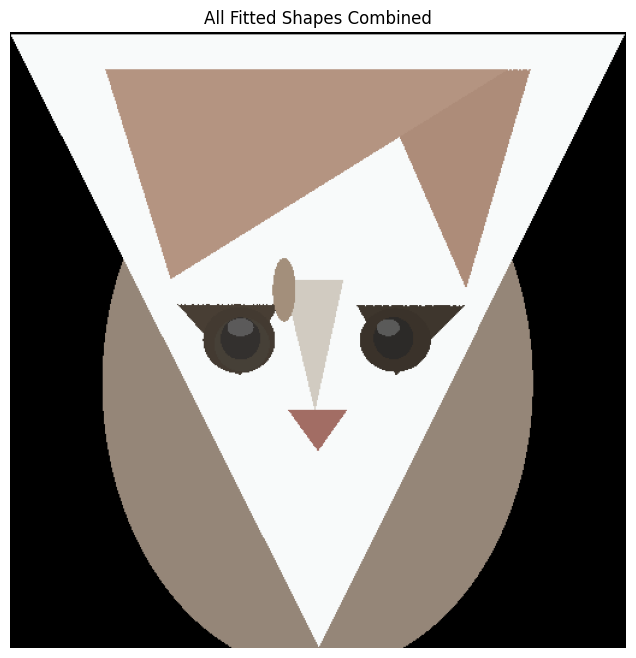

In [218]:
# 创建合并图像的空白画布
h, w, c = np.array(out).shape  # 获取图像大小
combined_image = np.zeros((h, w, c), dtype=np.uint8)  # 初始化合并画布

for mask in sorted_anns:
    segmentation = mask['segmentation']
    shape, params, error = fit_all_shapes(segmentation)
    print(f"最佳图形: {shape}, 参数: {params}, 误差: {error}")
    
    image_np = np.array(out)
    # 生成彩色基础图形
    colored_shape = generate_colored_shape(image_np, segmentation, shape, params)
    # 将彩色基础图形叠加到原图像上
    result_image = overlay_shapes(image_np, colored_shape)
    
    # 叠加当前基础图形到合并图像
    combined_image = overlay_shapes(combined_image, colored_shape)
    
    # 可视化单个结果
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 创建1行3列的子图
    # 子图1：显示原图与分割
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image with Segmentation")
    axes[0].axis("off")
    
    # 子图2：显示拟合图形
    axes[1].imshow(colored_shape)
    axes[1].set_title(f"Fitted {shape.capitalize()} with Color")
    axes[1].axis("off")
    
    # 子图3：显示拟合图形与原图结合
    axes[2].imshow(result_image)
    axes[2].set_title(f"Fitted {shape.capitalize()} with Original Image")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()

# 显示所有基础图形叠加的合并图像
plt.figure(figsize=(8, 8))
plt.imshow(combined_image)
plt.title("All Fitted Shapes Combined")
plt.axis("off")
plt.show()


In [ ]:
image_np = np.array(out)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image with Segmentation")
plt.imshow(image_np)
plt.axis("off")

segmentation = sorted_anns[4]['segmentation']
shape, params, error = fit_all_shapes(segmentation)
print(f"最佳图形: {shape}, 参数: {params}, 误差: {error}")

# 生成彩色基础图形
colored_shape = generate_colored_shape(image_np, segmentation, shape, params)
# 将彩色基础图形叠加到原图像上
# result_image = overlay_shapes(image_np, colored_shape)

# 可视化结果
fitted_mask = generate_shape_mask(params, shape, segmentation.shape)

plt.subplot(1, 2, 2)
plt.title(f"Fitted {shape_type.capitalize()} with Color")
plt.imshow(colored_shape)
plt.axis("off")
plt.show()

In [145]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from skimage.measure import find_contours

def calculate_error(segmentation, shape_mask):
    """
    计算误差：综合面积差和边界不匹配的惩罚
    """
    intersection = np.sum(segmentation & shape_mask)
    union = np.sum(segmentation | shape_mask)
    boundary_mismatch = np.sum(shape_mask & ~segmentation)  # 超出区域的像素数量
    if union == 0:
        return float("inf")
    return 1 - intersection / union + 0.01 * boundary_mismatch  # 综合面积和边界

def generate_shape_mask(params, shape_type, image_size):
    """
    根据参数生成图形掩码
    """
    mask = np.zeros(image_size, dtype=bool)
    h, w = image_size
    y, x = np.ogrid[:h, :w]

    if shape_type == "circle":
        cx, cy, r = params
        mask = (x - cx)**2 + (y - cy)**2 <= r**2

    elif shape_type == "ellipse":
        cx, cy, a, b, theta = params
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        x_shifted, y_shifted = x - cx, y - cy
        x_rotated = cos_theta * x_shifted + sin_theta * y_shifted
        y_rotated = -sin_theta * x_shifted + cos_theta * y_shifted
        mask = (x_rotated / a)**2 + (y_rotated / b)**2 <= 1

    elif shape_type == "rectangle":
        cx, cy, w, h, theta = params
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        x_shifted, y_shifted = x - cx, y - cy
        x_rotated = cos_theta * x_shifted + sin_theta * y_shifted
        y_rotated = -sin_theta * x_shifted + cos_theta * y_shifted
        mask = (np.abs(x_rotated) <= w / 2) & (np.abs(y_rotated) <= h / 2)

    elif shape_type == "triangle":
        x1, y1, x2, y2, x3, y3 = params
        triangle = np.zeros(image_size, dtype=bool)
        for i in range(h):
            for j in range(w):
                p = np.array([j, i])
                v0 = np.array([x3 - x1, y3 - y1])
                v1 = np.array([x2 - x1, y2 - y1])
                v2 = np.array([p[0] - x1, p[1] - y1])
                dot00 = np.dot(v0, v0)
                dot01 = np.dot(v0, v1)
                dot02 = np.dot(v0, v2)
                dot11 = np.dot(v1, v1)
                dot12 = np.dot(v1, v2)
                inv_denom = 1 / (dot00 * dot11 - dot01 * dot01)
                u = (dot11 * dot02 - dot01 * dot12) * inv_denom
                v = (dot00 * dot12 - dot01 * dot02) * inv_denom
                if u >= 0 and v >= 0 and (u + v) <= 1:
                    triangle[i, j] = True
        return triangle

    return mask

def fit_shape(segmentation, shape_type, initial_params, bounds, image_size):
    """
    优化形状参数以最小化误差
    """
    def objective(params):
        shape_mask = generate_shape_mask(params, shape_type, image_size)
        return calculate_error(segmentation, shape_mask)

    result = minimize(objective, initial_params, bounds=bounds)
    return result.x, result.fun

def get_initial_params_and_bounds(segmentation, shape_type):
    """
    根据分割区域生成初始参数和边界
    """
    h, w = segmentation.shape
    y, x = np.nonzero(segmentation)
    cx, cy = np.mean(x), np.mean(y)

    if shape_type == "circle":
        r = np.sqrt((x.max() - x.min())**2 + (y.max() - y.min())**2) / 2
        return [cx, cy, r], [(0, w), (0, h), (1, max(w, h))]

    elif shape_type == "ellipse":
        a, b = (x.max() - x.min()) / 2, (y.max() - y.min()) / 2
        return [cx, cy, a, b, 0], [(0, w), (0, h), (1, max(w, h)), (1, max(w, h)), (0, 2 * np.pi)]

    elif shape_type == "rectangle":
        w, h = x.max() - x.min(), y.max() - y.min()
        return [cx, cy, w, h, 0], [(0, w), (0, h), (1, max(w, h)), (1, max(w, h)), (0, 2 * np.pi)]

    elif shape_type == "triangle":
        contours = find_contours(segmentation, 0.5)
        if len(contours) == 0:
            raise ValueError("无法找到分割区域的轮廓")
        contour = contours[0]
        x1, y1 = contour[0]
        x2, y2 = contour[len(contour) // 3]
        x3, y3 = contour[2 * len(contour) // 3]
        return [x1, y1, x2, y2, x3, y3], [(0, w), (0, h)] * 3

def fit_all_shapes(segmentation):
    """
    对所有基础图形拟合，并选择误差最小的结果
    """
    shapes = ['circle', 'ellipse', 'rectangle', 'triangle']
    best_shape = None
    best_error = float('inf')
    best_params = None

    for shape_type in shapes:
        initial_params, bounds = get_initial_params_and_bounds(segmentation, shape_type)
        params, error = fit_shape(segmentation, shape_type, initial_params, bounds, segmentation.shape)
        if error < best_error:
            best_shape = shape_type
            best_error = error
            best_params = params

    return best_shape, best_params, best_error

def plot_result(segmentation, best_params, best_shape, image_size):
    """
    绘制结果
    """
    fitted_mask = generate_shape_mask(best_params, best_shape, image_size)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Segmentation")
    plt.imshow(segmentation, cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"Fitted Shape: {best_shape}")
    plt.imshow(fitted_mask, cmap="gray")
    plt.show()

In [ ]:
# for mask in sorted_anns:
#     segmentation = mask['segmentation']
segmentation = sorted_anns[5]['segmentation']
shape, params, error = fit_all_shapes(segmentation)
print(f"最佳图形: {shape}, 参数: {params}, 误差: {error}")

# 可视化结果
plot_result(segmentation, params, shape, segmentation.shape)